# LSTM model

Libraries import

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import datetime as dt
import numpy as np
import pickle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import load_model


from sklearn.metrics import mean_squared_error, mean_absolute_error

CSV file reading

In [5]:
# Read the CSV file
all_data = pd.read_csv("excel_data/data_ready_for_training.csv")
all_data.drop('Unnamed: 0',axis='columns', inplace=True)
all_data = all_data[["relh", "skph", "temp", "minutes"]]

In [6]:
all_data.head()

,relh,skph,temp,minutes
0,100.0,0.000,-2.0,0
1,100.0,0.000,-2.0,30
2,100.0,3.704,-2.0,0
3,100.0,0.000,-2.0,30
4,100.0,5.556,-3.0,0


Tranformation and split data

In [7]:
# GLOBAL
training_mean = []
training_std = []

In [8]:
def standard_score(X, y, index, training_mean, training_std, timestamps_count = 0):
    X[:, :, index] = (X[:, :, index] - training_mean) / training_std
    y[:, index] = (y[:, index] - training_mean) / training_std


def transform_and_split_data(df_input, window_size = 6, test_size = 0.1,  valid_size = 0.1, timestamps_count = 0):
    df = df_input.to_numpy()
    features_len = df_input.shape[1]
    data_count = len(df)
    X = []
    y = []
    # Explanatory X and Response y variables 
    for i in range(data_count-window_size - timestamps_count):
        row = [r for r in df[i:i+window_size]]
        X.append(row)
        label = [df[i+window_size + timestamps_count]]
        y.append(label)
    X = np.array(X)
    y = np.array(y)

    resh0 = y.shape[0]
    resh1 = y.shape[2]
    y = y.reshape(resh0, resh1)
    # data split
    train_size = 1 - test_size - valid_size
    train_last_el = int(data_count * train_size)
    valid_last_el = train_last_el + int(data_count * valid_size)

    X_train, y_train = X[:train_last_el], y[:train_last_el]

    X_val, y_val = X[train_last_el:valid_last_el], y[train_last_el:valid_last_el]
    X_test, y_test = X[valid_last_el:], y[valid_last_el:]

    training_mean = []
    training_std = []
    # data normalization
    for i in range(features_len):
        training_mean.append(np.mean(X[:, :, i]))
        training_std.append(np.std(X[:, :, i]))
        standard_score(X_train, y_train, i, training_mean[i], training_std[i])
        standard_score(X_val, y_val, i, training_mean[i], training_std[i])
        standard_score(X_test, y_test, i, training_mean[i], training_std[i])

    return  X_train, y_train, X_val, y_val, X_test, y_test,training_mean, training_std

LSTM model init, learn and save

In [33]:
# neural network model
def LSTM_model(X_train, y_train, X_val, y_val, epochs =10, learning_rate=0.001, window_size = 6):
    model = Sequential()
    model.add(InputLayer((window_size, 3)))
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(32, 'ReLU')) # previous was ReLU
    model.add(Dense(3, 'linear'))
    # model = Sequential()
    # model.add(LSTM(64, return_sequences=True, input_shape=(window_size, 3)))
    # model.add(LSTM(16, 'ReLU')) # previous was ReLU
    # model.add(Dense(32, 'ReLU')) # previous was ReLU
    # model.add(Dense(3, 'linear'))

    # cp = ModelCheckpoint('LSTM_model', save_best_only=True)
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate= learning_rate), metrics=[RootMeanSquaredError()])
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size = 128)#, callbacks=[cp])
    return model

Make predicitions and plot output

In [7]:
def denormalization(y, training_mean, training_std):
  y = (y*training_std) + training_mean
  return y

def make_predictions(model, X, y,  training_mean, training_std):
  predictions = model.predict(X)
  
  features_len = y.shape[1]
  pred = []
  actual =[]

  for i in range(features_len):
    pred.append(denormalization(predictions[:,i], training_mean[i], training_std[i]))
    actual.append(denormalization(y[:,i], training_mean[i], training_std[i]))

  return pred, actual

def plot_predictions_and_actual(pred, actual, start=24, end=48):

  fig, axs = plt.subplots(4)
  fig.suptitle('Weather parameters - red means predicted')
  fig.tight_layout(pad=1.8)
  axs[0].plot(pred[0][start:end],'r')
  axs[0].plot(actual[0][start:end])
  axs[0].set_title('relative humidity')

  axs[1].plot(pred[1][start:end],'r')
  axs[1].plot(actual[1][start:end])
  axs[1].set_title('speed of wind')

  axs[2].plot(pred[2][start:end],'r')
  axs[2].plot(actual[2][start:end])
  axs[2].set_title('temperature')

  axs[3].plot(actual[2][:])
  axs[3].set_title('temperature')




MSE calculations for given window size and etc. for the next 1 to 5 hours

In [34]:
# MSE calculations for given window size and etc. in next 1 to 3 next hours
# last_pred_hour == 3 means that predictions are from +1 hour till +3 hours
window_size = 6
test_size = 0.1
valid_size = 0.1
epochs = 10
learning_rate=0.001


def return_time(window_size,test_size,valid_size,epochs,learning_rate):
    
    MSE_humid = []
    MAE_humid = []

    MSE_wind = []
    MAE_wind = []
    
    MSE_temp = []
    MAE_temp = []

    last_pred_hour = 3
    for hour in range(last_pred_hour-1,last_pred_hour):
        # (hour == 0) it means that predictions will be made for next one hour
        X_train, y_train, X_val, y_val, X_test, y_test,training_mean, training_std = transform_and_split_data(all_data.copy(), window_size, test_size, valid_size, hour)
        X_test.size
        model = LSTM_model(X_train, y_train, X_val, y_val, epochs, learning_rate, window_size)
            

        ## save as binary file .pkl
        # file_name = "lstm12_" + str(hour+1) + ".pkl"
        # with open(file_name, "xb") as f_1:
        #     pickle.dump(model, f_1, -1)

        pred, actaul = make_predictions(model, X_test, y_test,  training_mean, training_std)
        MSE_humid.append(mean_squared_error(actaul[0], pred[0]))
        MAE_humid.append(mean_absolute_error(actaul[0], pred[0]))
        MSE_wind.append(mean_squared_error(actaul[1], pred[1]))
        MAE_wind.append(mean_absolute_error(actaul[1], pred[1]))
        MSE_temp.append(mean_squared_error(actaul[2], pred[2]))
        MAE_temp.append(mean_absolute_error(actaul[2], pred[2]))


    return MSE_humid, MAE_humid, MSE_wind, MAE_wind, MSE_temp, MAE_temp, pred, actaul

MSE_humid, MAE_humid, MSE_wind, MAE_wind, MSE_temp, MAE_temp, pred, actaul  = return_time(window_size,test_size,valid_size,epochs,learning_rate)

Epoch 1/10
471/471 [==============================] - 6s 8ms/step - loss: 0.3210 - root_mean_squared_error: 0.5665 - val_loss: 0.2697 - val_root_mean_squared_error: 0.5193
Epoch 2/10
471/471 [==============================] - 3s 7ms/step - loss: 0.2528 - root_mean_squared_error: 0.5027 - val_loss: 0.2607 - val_root_mean_squared_error: 0.5106
Epoch 3/10
471/471 [==============================] - 3s 7ms/step - loss: 0.2449 - root_mean_squared_error: 0.4949 - val_loss: 0.2527 - val_root_mean_squared_error: 0.5027
Epoch 4/10
471/471 [==============================] - 3s 7ms/step - loss: 0.2402 - root_mean_squared_error: 0.4901 - val_loss: 0.2511 - val_root_mean_squared_error: 0.5011
Epoch 5/10
471/471 [==============================] - 3s 7ms/step - loss: 0.2374 - root_mean_squared_error: 0.4872 - val_loss: 0.2468 - val_root_mean_squared_error: 0.4968
Epoch 6/10
471/471 [==============================] - 3s 7ms/step - loss: 0.2347 - root_mean_squared_error: 0.4844 - val_loss: 0.2452 - val_

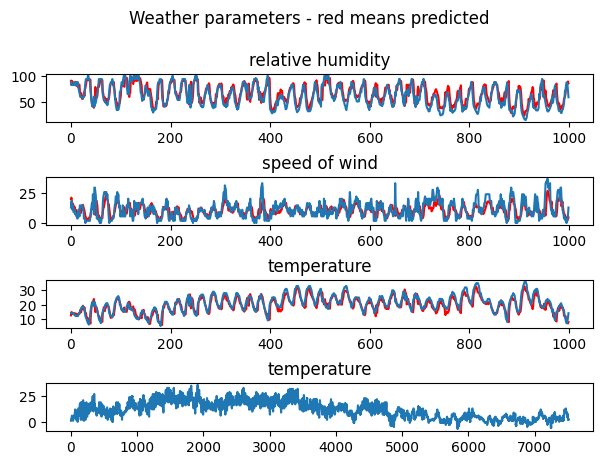

In [22]:
# plot the output
plot_predictions_and_actual(pred, actaul,1000,2000)

In [35]:
# MSE errors for predictions for next hour, two next hours, ... , five next hours
print(MAE_humid)
print(MAE_wind)
print(MAE_temp)
# for valid size = 0.2 and test size = 0.1 : MAE == 1.69

[7.048568697070911]
[3.8026840698087834]
[1.525382891961774]


In [11]:
X_train, y_train, X_val, y_val, X_test, y_test,training_mean, training_std = transform_and_split_data(all_data.copy(), window_size, test_size, valid_size, 0)
X_test[0]

array([[-1.75538491,  1.35515183, -0.34986041],
       [-1.93417057,  1.11525751, -0.34986041],
       [-1.77109638,  0.15568019, -0.46057263],
       [-1.77109638, -0.08421414, -0.46057263],
       [-1.38968697,  0.39557452, -0.57128485],
       [-0.94814056,  0.15568019, -0.68199708]])

##  Training data save

In [12]:
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)
np.savetxt("X_test.txt", X_test_reshaped)
np.savetxt("y_test.txt", y_test)

In [14]:
# relh	 skph 	temp
training_mean
training_std

mean_and_std = pd.DataFrame()
mean_and_std['mean'] = training_mean
mean_and_std['std'] = training_std

mean_and_std.to_csv("mean_and_std")